## Resolved TKE budget

This notebook diagnoses the TKE budget for horizontally homogeneous turbulence from PALM output:
$$\begin{equation}
\frac{\partial e}{\partial t} =
\underbrace{
-\overline{u'w'}\frac{\partial \overline{u}}{\partial z}
-\overline{v'w'}\frac{\partial \overline{v}}{\partial z}
}_{P}
\underbrace{
-\overline{u'w'}\frac{\partial \overline{u}^S}{\partial z}
-\overline{v'w'}\frac{\partial \overline{v}^S}{\partial z}
}_{P^S}
+\underbrace{
\overline{w'b'}
}_{B}
\underbrace{
-\frac{\partial}{\partial z}\left(\frac{\overline{w'p'}}{\rho_0}+\overline{w'e}\right)
}_{T}
+D,
\end{equation}$$
where $P$ is the shear production, $P^S$ is the Stokes production, $B$ is the buoyancy production, $T$ is the TKE transport and $D$ is the dissipation.

In [1]:
%matplotlib inline
%config IPCompleter.greedy=True
from lesanalysis import *

In [2]:
palmcase      = '/Users/qingli/data/palm/MSM97-ST'
inputfile_pfl = palmcase+'/DATA_1D_PR_NETCDF'
data_pfl      = PALMData1DPR(inputfile_pfl)

### Parameters 

In [3]:
# gravitational acceleration (m/s^2)
g = 9.81
# thermal expansion coefficient (1/degC)
# TODO: constant for now, may need to read from output in PALM
alpha = 2.0e-4
# saline contraction coefficient (1/psu)
# TODO: constant for now, may need to read from output in PALM
beta = 8.0e-4
# spin-up time (s)
tspinup = 0.
# averaging period (s)
# deltat = 2*np.pi/f # last inertial period
deltat = 3600. # last hour

### Time

In [4]:
# mean profile
time = data_pfl.dataset.variables['time'][:]
ttarget = time[-1]-deltat
assert ttarget>tspinup, 'Run time too short for average over the last inertial period.'
tidx_start = np.argmin(np.abs(time-ttarget))
tidx_end = -1
print('Time period for average: {} s - {} s'.format(time[tidx_start], time[tidx_end]))

Time period for average: 82810.90000000004 s - 86409.99999999997 s


### Resolved TKE budget

In [5]:
# load mean profiles, interpolate on w level, exclude first and last element
zu = data_pfl.dataset.variables['zu'][:]
uw = data_pfl.read_profile('w*u*', tidx_start=tidx_start, tidx_end=tidx_end).data_mean[1:-1]
vw = data_pfl.read_profile('w*v*', tidx_start=tidx_start, tidx_end=tidx_end).data_mean[1:-1]
U = data_pfl.read_profile('u', tidx_start=tidx_start, tidx_end=tidx_end).data_mean
V = data_pfl.read_profile('v', tidx_start=tidx_start, tidx_end=tidx_end).data_mean
dUdz = (U[2:]-U[1:-1])/(zu[2:]-zu[1:-1])
dVdz = (V[2:]-V[1:-1])/(zu[2:]-zu[1:-1])
if 'u_stk' in data_pfl.list_variables:
    Ustk = data_pfl.read_profile('u_stk', tidx_start=tidx_start, tidx_end=tidx_end).data_mean
    Vstk = data_pfl.read_profile('v_stk', tidx_start=tidx_start, tidx_end=tidx_end).data_mean
    dUstkdz = (Ustk[2:]-Ustk[1:-1])/(zu[2:]-zu[1:-1])
    dVstkdz = (Vstk[2:]-Vstk[1:-1])/(zu[2:]-zu[1:-1])
else:
    dUstkdz = np.zeros(dUdz.size)
    dVstkdz = np.zeros(dVdz.size)
wpt = data_pfl.read_profile('w*pt*', tidx_start=tidx_start, tidx_end=tidx_end).data_mean[1:-1]
wsa = data_pfl.read_profile('w*sa*', tidx_start=tidx_start, tidx_end=tidx_end).data_mean[1:-1]
wb = g*(wpt*alpha+wsa*beta)
dwedz_zu = data_pfl.read_profile('w*u*u*:dz', tidx_start=tidx_start, tidx_end=tidx_end).data_mean
dwedz = 0.5*(dwedz_zu[1:-1]+dwedz_zu[2:])
dwpdz_zu = data_pfl.read_profile('w*p*:dz', tidx_start=tidx_start, tidx_end=tidx_end).data_mean
dwpdz = 0.5*(dwpdz_zu[1:-1]+dwpdz_zu[2:])
# TODO: read dissipation
zw = data_pfl.dataset.variables['zw'][1:-1]


In [6]:
# shear production
P = -uw*dUdz-vw*dVdz
# Stokes production
PS = -uw*dUstkdz-vw*dVstkdz
# buoyancy production
B = wb
# TKE transport
T = -dwedz-dwpdz
# dissipation
# TODO: inferred dissipation for now, need to add to PALM output
D = -(P+PS+B+T)

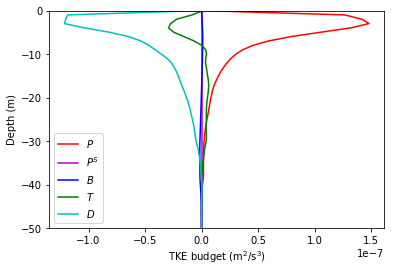

In [7]:
# plot TKE budget
plt.plot(P, zw, '-r', label='$P$')
plt.plot(PS, zw, '-m', label='$P^S$')
plt.plot(B, zw, '-b', label='$B$')
plt.plot(T, zw, '-g', label='$T$')
plt.plot(D, zw, '-c', label='$D$')
plt.ylim([-50, 0])
plt.ylabel('Depth (m)')
plt.xlabel('TKE budget (m$^2$/s$^3$)')
plt.legend(loc='lower left')